In [1]:
# 导入所需要的依赖
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn import preprocessing

In [2]:
# 读取数据文件
df = pd.read_excel('./train.xlsx', header=0)

# 脏值处理
# 所有为空的数据，均填入该列的平均值 TODO how to fill empty cell?
keys = ['RISK_STDEVYEARLY','RISK_MAXDOWNSIDE','RISK_SHARPE','RISK_TREYNOR','RETURN_1M','RETURN_1Y','RETURN_3Y','PERIODRETURNRANKING_1M','PERIODRETURNRANKING_1Y','PERIODRETURNRANKING_3Y','resultValue']
for key in keys :
    mean = df[key].mean()
    df[key] = df[key].fillna(mean)
    
    
# 获取df值
df = df.values

# 转成numpy处理
df = np.array(df) 

In [3]:
# 因子数量 10个 
# RISK_STDEVYEARLY	RISK_MAXDOWNSIDE	RISK_SHARPE	RISK_TREYNOR	RETURN_1M	RETURN_1Y	RETURN_3Y	
# PERIODRETURNRANKING_1M	PERIODRETURNRANKING_1Y	PERIODRETURNRANKING_3Y
FACTOR_COUNT = 10 

# x_data 基于历史提取的相关因子数据
x_data = df[:,:FACTOR_COUNT]
# y_data 最新一个月的收益率
y_data = df[:,FACTOR_COUNT]

# 特征值归一化
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
x_data = minmax_scale.fit_transform(x_data)


In [4]:
# 定义模型
x = tf.placeholder(tf.float32, [None, FACTOR_COUNT], name = 'X')
y = tf.placeholder(tf.float32, [None, 1], name = 'Y')

# 定义命名空间，使得计算图更可读
with tf.name_scope("model"):
    w = tf.Variable(tf.random_normal([FACTOR_COUNT, 1], stddev=0.01), name='W')
    b = tf.Variable(1.0, name='b')
    
    # 模型用多元回归模型，叉乘即可
    def model(x,w,b):
        return tf.matmul(x,w)+b
    
    pred = model(x,w,b)  # 预测值
    train_epochs = 50    # 迭代次数（训练轮数）
    learing_rate = 0.01  # 学习率（步长）

In [5]:
# 定义损失函数，选用均方误差
with tf.name_scope("LossFunction"):
    loss_function = tf.reduce_mean(tf.pow(y-pred, 2)) # 均方误差
    optimizer = tf.train.GradientDescentOptimizer(learing_rate).minimize(loss_function) # 优化器选用GDO
    

epoch= 1  loss= 2.66800878098  b= 2.09347  w= [[ 3.24025774]
 [-1.12551653]
 [ 1.0461762 ]
 [ 0.053043  ]
 [ 8.42644596]
 [ 1.00326407]
 [ 0.9112888 ]
 [-6.84052515]
 [-0.61693466]
 [-0.1600118 ]]
epoch= 2  loss= 1.7897408791  b= 1.34273  w= [[  3.44477677]
 [ -1.07606947]
 [  0.2795746 ]
 [  0.06760527]
 [ 11.20195198]
 [  0.54577941]
 [  0.69698244]
 [ -5.57975817]
 [ -0.7498095 ]
 [ -0.12850118]]
epoch= 3  loss= 1.60989967002  b= 0.782755  w= [[  3.54433894]
 [ -0.89313185]
 [ -0.28704643]
 [  0.07330935]
 [ 13.50407791]
 [  0.27195257]
 [  0.59099323]
 [ -4.72895575]
 [ -0.9503504 ]
 [ -0.14933608]]
epoch= 4  loss= 1.49606572956  b= 0.318746  w= [[  3.59173822]
 [ -0.75027227]
 [ -0.73646826]
 [  0.05793464]
 [ 15.36164379]
 [  0.05158802]
 [  0.56766611]
 [ -4.06483603]
 [ -1.08771944]
 [ -0.26117554]]
epoch= 5  loss= 1.41868536897  b= -0.0922191  w= [[  3.65482545]
 [ -0.63996714]
 [ -1.13076615]
 [  0.04053111]
 [ 16.68967247]
 [ -0.23396464]
 [  0.42490387]
 [ -3.36594009]
 [ -

<IPython.core.display.Javascript object>


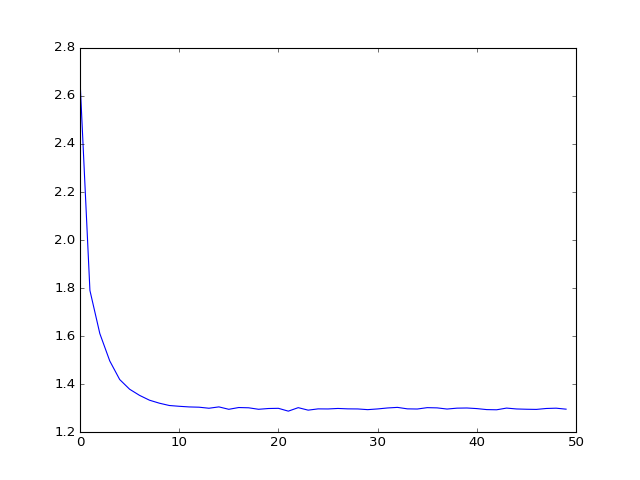

=========================train data=========================
Loss Average = 1.29512372322


In [6]:
# 开始训练
sess = tf.Session()
sess.run(tf.global_variables_initializer())


loss_list = [] # 每轮添加一个average
loss_list2 = [] # 每次样本记录一个loss

# 写入计算图
tf.reset_default_graph()
logdir='D:/work/log'
writer = tf.summary.FileWriter(logdir, sess.graph)
# 创建一个操作，用于记录损失值loss，后面再TensorBoard中scalars栏可见
sum_loss_op = tf.summary.scalar("loss", loss_function)
# 把所有记录摘要日志文件合并，方便一次写入
merged = tf.summary.merge_all()

for epoch in range(train_epochs):
    loss_sum = 0.0
    for xs, ys in zip(x_data, y_data):
        xs = xs.reshape(1,FACTOR_COUNT)
        ys = ys.reshape(1,1)
        
        # 增加summary_dir 记录到计算图
        _,summary_str, loss = sess.run([optimizer,sum_loss_op, loss_function], feed_dict={
            x:xs, y:ys
        })
        writer.add_summary(summary_str, epoch)
        
        loss_sum = loss_sum + loss
        loss_list2.append(loss)
        
    # 打乱样本集
    x_data, y_data = shuffle(x_data, y_data)

    b0temp = b.eval(session = sess)
    w0temp = w.eval(session = sess)
    loss_average = loss_sum/len(y_data)

    print("epoch=", epoch+1, " loss=",loss_average, " b=", b0temp, " w=", w0temp)
    # 每轮记录一次评价loss
    loss_list.append(loss_average)
# 可视化loss
plt.plot(loss_list)

print("=========================train data=========================")
print('Loss Average =',loss_average)


In [7]:
# 评估模型
_df = pd.read_excel('./verify.xlsx', header=0)
for key in keys :
    mean = _df[key].mean()
    _df[key] = _df[key].fillna(mean)
    
_df = _df.values
_df = np.array(_df) 


x_test = _df[:,:FACTOR_COUNT]
y_test = _df[:,FACTOR_COUNT]
x_test = minmax_scale.fit_transform(x_test)

loss_sum = 0.0
for xs, ys in zip(x_test, y_test):
    xs = xs.reshape(1,FACTOR_COUNT)
    ys = ys.reshape(1,1)

    _, loss = sess.run([optimizer,loss_function], feed_dict={
        x:xs, y:ys
    })
    writer.add_summary(summary_str, epoch)

    loss_sum = loss_sum + loss


b0temp = b.eval(session = sess)
w0temp = w.eval(session = sess)
loss_average = loss_sum/len(y_data)
print("=========================test data=========================")
print('Loss Average =',loss_average)
print('W =',w0temp)

=========================test data=========================
Loss Average = 0.461044305035
W = [[  3.55317092]
 [ -0.50206566]
 [ -2.37958837]
 [ -1.44542503]
 [ 21.88003159]
 [ -1.07046938]
 [  1.73149765]
 [ -0.67919838]
 [ -1.56827462]
 [  0.20226558]]
